# Exploratory data anaylsis

## Examine the data

The dataset we are working with is an excel speadsheet with different sheets for each year. What does the data look like?

In [1]:
import pandas as pd
data_path = "../data/raw/Historical Station Counts by State 2007-2021.xlsx"
df = pd.read_excel(data_path, sheet_name='2020', skiprows=1)
df

,State,Biodiesel,CNG,E85,Electrica,Hydrogenb,LNG,Propanec,Totald
0,NaN,NaN,NaN,NaN,(stations / charging outlets,(retail / non-retail / total),NaN,(primary / secondary / total),NaN
1,NaN,NaN,NaN,NaN,Level 1 / Level 2 / DC Fast),NaN,NaN,NaN,NaN
2,Alabama,10.0,30.0,29.0,223 / 596,0 / 0 / 0,2.0,24 / 45 / 69,736.0
3,NaN,NaN,NaN,NaN,56 / 449 / 91,NaN,NaN,NaN,NaN
4,Alaska,0.0,1.0,0.0,25 / 45,0 / 0 / 0,0.0,1 / 2 / 3,49.0
...,...,...,...,...,...,...,...,...,...
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,(a) Includes legacy chargers but does not incl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,(b) Primary propane stations offer vehicle-spe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,(c) Retail hydrogen stations accept payment at...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.dropna(how="all")
    df_cleaned = df_cleaned.rename(columns={"Totald" : "Total"})
    df_cleaned = df_cleaned[["State", "Total"]]
    df_cleaned = df_cleaned.dropna()
    df_cleaned['State'] = df_cleaned['State'].astype('category')
    return df_cleaned

df_total = pd.DataFrame()
for n in range(2007, 2022, 1):
    df = pd.read_excel(data_path, sheet_name=str(n), skiprows=1)
    df_cleaned = clean_data(df)
    df_cleaned["Year"] = n
    df_total = pd.concat([df_total, df_cleaned])

Get some general info about the data

In [3]:
df_total.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 2 to 104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   State   780 non-null    category
 1   Total   780 non-null    float64 
 2   Year    780 non-null    int64   
dtypes: category(1), float64(1), int64(1)
memory usage: 21.5 KB


In [4]:
df_total.describe(include='all')

,State,Total,Year
count,780,780.000000,780.000000
unique,52,NaN,NaN
top,Alabama,NaN,NaN
freq,15,NaN,NaN
mean,NaN,1802.579487,2014.000000
std,NaN,8917.620078,4.323266
min,NaN,6.000000,2007.000000
25%,NaN,112.000000,2010.000000
50%,NaN,294.500000,2014.000000
75%,NaN,969.250000,2018.000000


Check how many missing values we have

In [5]:
df_total.isna().mean()

State    0.0
Total    0.0
Year     0.0
dtype: float64

What are the states?

In [6]:
df.State.value_counts()

Alabama                                                                                                                                                                                                                                                                                                                                                                                        1
Alaska                                                                                                                                                                                                                                                                                                                                                                                         1
New Jersey                                                                                                                                                                                                                            

The data is a bit of a mess because of footnotes in the excel spreadsheet. Also, there are 52 states in the data so we can expect the results to be noise - you can see this from the percentile cuts on the `Total` data above.

For simplicity, let's trim down to rows with "Total" in the `State` column. This has the added bonus that it makes the problem univariate.

Let's also make the `Year` column a timestamp and set it to be the index. Hint: When we want to make a prediction we will want to use datetime stamps rather than integer row indices as that is what we would want to use in a predict API

/var/folders/vc/2v8cvy_11715btkp90f5tzyw0000gn/T/ipykernel_77671/3877052923.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = df_total[df['State'] == 'Total']


<AxesSubplot: xlabel='Year'>

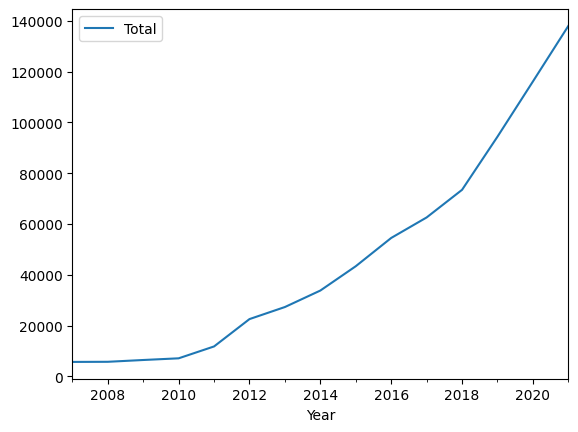

In [7]:
y = df_total[df['State'] == 'Total']
y = y.drop('State', axis=1)
y.Year = pd.to_datetime(y.Year, format="%Y")
y = y.reset_index(drop=True)
y = y.set_index('Year')
y.plot()

## Fit an auto-regressive time series model


Split the data into train and test. Make sure not to shuffle as we want the time order to be preserved for future forecasting.

In [9]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y, shuffle=False)
y_train
y_test

,Total
Year,
2018-01-01,73475.0
2019-01-01,94410.0
2020-01-01,116146.0
2021-01-01,138020.0


In [10]:
from statsmodels.tsa.ar_model import AutoReg
model_ag = AutoReg(endog = y_train, \
                   lags = 1, \
                   trend='c', \
                   seasonal = False, \
                   exog = None, \
                   hold_back = None, \
                   period = None, \
                   missing = 'none')
fit_ag = model_ag.fit()
print("Coefficients:\n%s" % fit_ag.params)

Coefficients:
const       2093.409028
Total.L1       1.164707
dtype: float64


/Users/rossparkin/Projects/ak/mlops-workshop/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [11]:
y_pred = fit_ag.predict(start=y_test.index[0], \
                        end=y_test.index[-1], \
                        dynamic=False)

/Users/rossparkin/Projects/ak/mlops-workshop/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Plot the prediction vs the training data

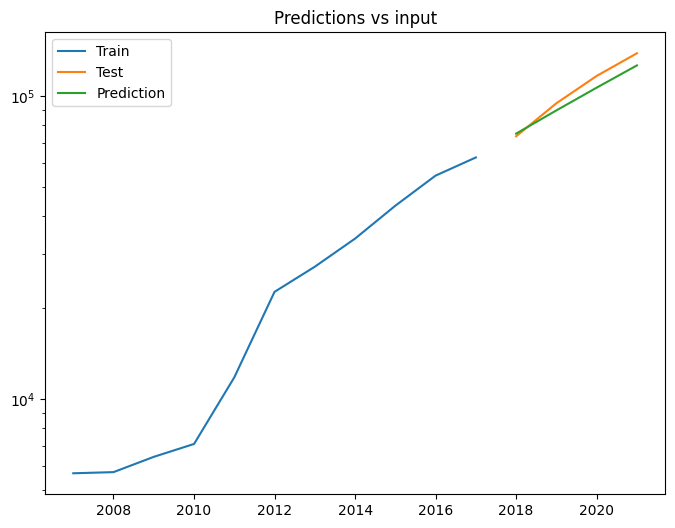

In [12]:
import matplotlib.pyplot as plt
def plot_predictions(train, test, pred):
    plt.figure(figsize=(8,6))
    plt.plot(train.index, train.Total, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(pred.index, pred, label='Prediction')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.title("Predictions vs input")
    plt.show()
plot_predictions(y_train, y_test, y_pred)

For comparison, get some scores for the model using a test set

In [13]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test.values, y_pred.values)

0.06162257758106782

Out of interest, what do the predictions look like out into the future, say to 2040?

/Users/rossparkin/Projects/ak/mlops-workshop/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


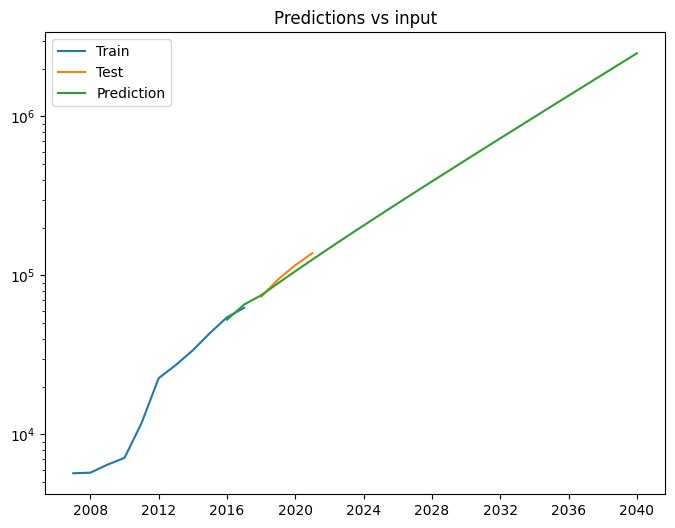

In [14]:
from datetime import datetime
y_pred2 = fit_ag.predict(start=datetime(2016, 1, 1), \
                             end=datetime(2040, 1, 1), \
                             dynamic=False)

plot_predictions(y_train, y_test, y_pred2)

How do we then make a single prediction

In [15]:
single_prediction = fit_ag.predict(start=datetime(2020, 1, 1), \
                             end=datetime(2020, 1, 1), \
                             dynamic=False)
single_prediction.values[0]

/Users/rossparkin/Projects/ak/mlops-workshop/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


106265.16854394488

## Saving the model to disk

In [16]:
import statsmodels.api as sm
model_path = "model.pickle"
fit_ag.save(model_path)
fit_ag2 = sm.load_pickle(model_path)
single_prediction2 = fit_ag2.predict(start=datetime(2020, 1, 1), \
                             end=datetime(2020, 1, 1), \
                             dynamic=False)
single_prediction2.values[0]

/Users/rossparkin/Projects/ak/mlops-workshop/.venv/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


106265.16854394488